# Quantum search with two qubits

In this problem we implement the Grover search algorithm on two qubits. That is, the search space has $N=4$ elements. You will need to give an algorithm for calculating the Grover operator. The Grover operator $G$ consists of two parts:  
* Oracle, $O$
* Phase shift, $2|0\rangle \langle 0| - I$

Then the Grover operator is given by  
$$
G = H^{\otimes 2} (2|0\rangle \langle 0|-I) H^{\otimes 2} O \ .
$$

You might need to install `pylatexenc`.

In [1]:
pip install pylatexenc

     |████████████████████████████████| 162 kB 8.9 MB/s eta 0:00:01
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136823 sha256=59a9f36816306d8a90a63ae51e565cc84b6cfc351ef493055771bcdef2de2328
  Stored in directory: /home/ponnia3/.cache/pip/wheels/72/99/be/81d9bcdf5dd5ee5acd8119a9dd5bc07204c9ce205fd341b021
Successfully built pylatexenc
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram

## Oracle

Implement first the oracle which satisfies  
$\mathcal O |x\rangle|q\rangle = |x\rangle|f(x) \oplus q\rangle$ ,  
where $|x\rangle$ is the 2 qubit register holds the search space and $|q\rangle$ is the oracle work space. The function $f(x)$ marks the element we are searching for, let's call this $x_0 \in \{0, 1, 2, 3\}$. Then $f(x)=1$ if $x=x_0$ and $f(x)=0$ otherwise.

<span style="color:red">Implement the function ``oracle`` which outputs a quantum circuit for the oracle.</span>  
Hint: you might find the doubly controlled not gate (QuantumCircuit.ccx()) useful.

In [2]:
?QuantumCircuit.ccx

Signature:
QuantumCircuit.ccx(
    self,
    control_qubit1: Union[qiskit.circuit.quantumregister.Qubit, qiskit.circuit.quantumregister.QuantumRegister, int, slice, Sequence[Union[qiskit.circuit.quantumregister.Qubit, int]]],
    control_qubit2: Union[qiskit.circuit.quantumregister.Qubit, qiskit.circuit.quantumregister.QuantumRegister, int, slice, Sequence[Union[qiskit.circuit.quantumregister.Qubit, int]]],
    target_qubit: Union[qiskit.circuit.quantumregister.Qubit, qiskit.circuit.quantumregister.QuantumRegister, int, slice, Sequence[Union[qiskit.circuit.quantumregister.Qubit, int]]],
    ctrl_state: Union[int, str, NoneType] = None,
) -> qiskit.circuit.instructionset.InstructionSet
Docstring:
Apply :class:`~qiskit.circuit.library.CCXGate`.

For the full matrix form of this gate, see the underlying gate documentation.

Args:
    control_qubit1: The qubit(s) used as the first control.
    control_qubit2: The qubit(s) used as the second control.
    target_qubit: The qubit(s) targeted 

In [3]:
"""
This function gives a circuit for an oracle which marks x_0.

Args:
    x_0: The number we search for and will be marked.
         Integer in range 0 <= x_0 < 4

Returns:
    QuantumCircuit on 3 qubits (2 for search register, 1 for oracle workspace)
    which implements the oracle.
"""
def oracle(x_0):
    circ = QuantumCircuit(3, name='Oracle')
    # Fill your gates here
    # Flip bits so that the correct x_0 triggers the ccx-gate
    if x_0 == 0:
        circ.x([0, 1])
    elif x_0 == 1:
        circ.x(1)
    elif x_0 == 2:
        circ.x(0)
    # Apply the doubly controlled not
    circ.ccx(0, 1, 2)
    # Undo bit flips to return the data register to its original state
    if x_0 == 0:
        circ.x([0, 1])
    elif x_0 == 1:
        circ.x(1)
    elif x_0 == 2:
        circ.x(0)
    # Finally return the oracle circuit
    return circ

You can test whether your oracle works like this:

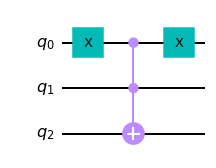

Input |0>  ->  Output {'000': (1+0j)}
Input |1>  ->  Output {'001': (1+0j)}
Input |2>  ->  Output {'110': (1+0j)}
Input |3>  ->  Output {'011': (1+0j)}


In [4]:
O = oracle(2)  # Test with any number
display(O.draw('mpl'))
for x in range(4):
    zero_state = Statevector.from_int(x, 2**3)   # 3 qubit state initialized to |x>|0>
    output_state = zero_state.evolve(O)          # Apply the oracle
    print(f'Input |{x}>  ->  Output {output_state.to_dict(3)}')

Does this look correct? Remember that Qiskit lists qubits from right to left, so for example '100' means that the data register is in state $|00\rangle$ and the workspace register is in state $|1\rangle$.

## Phase flip

The phase flip $\mathcal P$ acts only on the data register and satisfies  
$\mathcal P |0\rangle|q\rangle = |0\rangle|q\rangle$  
$\mathcal P |x\rangle|q\rangle = -|x\rangle|q\rangle$ if $x>0$.

<span style="color:red">Implement the function ``phase_flip`` which outputs a quantum circuit for the phase flip.</span>

In [5]:
"""
This function gives a circuit which flips phase only if the data register is not |00>.

Returns:
    QuantumCircuit on 3 qubits (2 for search register, 1 for oracle workspace)
    which implements the phase flip.
"""
def phase_flip():
    circ = QuantumCircuit(3, name='Phase')
    # Fill your gates here
    circ.z([0, 1])
    circ.cz(0, 1)
    # Finally return the phase flip circuit
    return circ

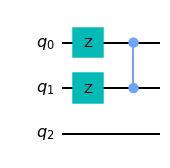

Input |0>  ->  Output {'000': (1+0j)}
Input |1>  ->  Output {'001': (-1+0j)}
Input |2>  ->  Output {'010': (-1+0j)}
Input |3>  ->  Output {'011': (-1+0j)}


In [6]:
P = phase_flip()
display(P.draw('mpl'))
for x in range(4):
    zero_state = Statevector.from_int(x, 2**3)   # 3 qubit state initialized to |x>|0>
    output_state = zero_state.evolve(P)          # Apply the phase flip
    print(f'Input |{x}>  ->  Output {output_state.to_dict(3)}')

## Grover operator

Now that we have implemented the oracle and the phase flip, we can use them to build the complete Grover operator.

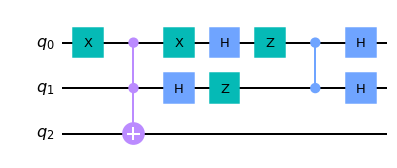

In [7]:
G = oracle(2)      # This chooses which element we search for
G.h([0, 1])
G = G.compose(phase_flip())
G.h([0, 1])
G.draw('mpl')

## Quantum search

Now the final step is to figure out how many times we need to apply the Grover operator in order to get the right answer.

<span style="color:red">Calculate how many times $R$ the Grover iteration has to be applied and fill it in the cell below.</span>

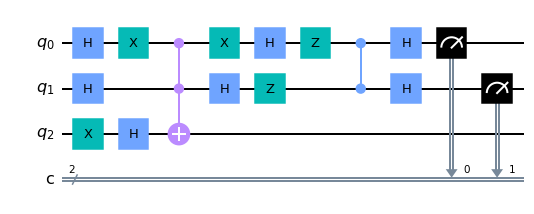

In [8]:
R = 1             # Add here how many times to repeat the Grover operator
# This builds the completed circuit
circ = QuantumCircuit(3, 2)
circ.h([0, 1])
circ.x(2)
circ.h(2)
for _ in range(R):
    circ = circ.compose(G)
circ.measure([0, 1], [0, 1])
circ.draw('mpl')

## Run the circuit

Now we test that the Grover search works.

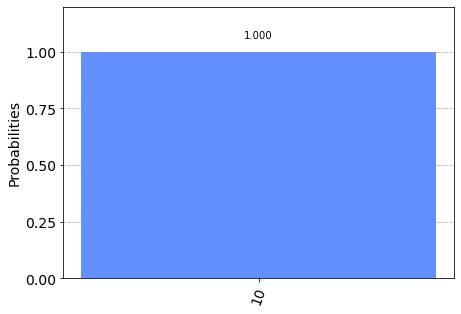

In [9]:
simulator = Aer.get_backend('qasm_simulator')

result = execute(circ, simulator).result()
counts = result.get_counts(circ)
plot_histogram(counts)

You should see that measurement matches your $x_0$.